# <center>Аналитика онлайн-сервиса продажи билетов<center>

### Цель проекта

Оптимизировать маркетинговые затраты онлайн сервиса продаж.


### Описание проекта

В распоряжении имеются данные от сервиса онлайн-прожажи за 1 год:

    - лог сервера с данными о посещениях сайта,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.

Необходимо изучить:

    * как люди пользуются продуктом,
    * когда они начинают покупать,
    * сколько денег приносит каждый клиент
    * когда клиент окупается.

### Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):

    Uid — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Start Ts — дата и время начала сессии
    End Ts — дата и время окончания сессии
    Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):

    Uid — уникальный id пользователя, который сделал заказ
    Buy Ts — дата и время заказа
    Revenue — выручка с этого заказа

Таблица costs (информация о затратах на маркетинг):

    source_id — идентификатор рекламного источника
    dt — дата
    costs — затраты на этот рекламный источник в этот день

### План работы

1. Загрузка данных и подготовка их к анализу
2. Анализ бизнес показателей: построение отчётов и подсчет метрик

   Отобразить на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?
   
   2.1. Продукт

    * Сколько людей пользуются в день, неделю, месяц?
    * Сколько сессий в день?
    * Сколько длится одна сессия?
    * Как часто люди возвращаются?

   2.2 Продажи

    * Когда люди начинают покупать?
    * Сколько раз покупают за период?
    * Какой средний чек?
    * Сколько денег приносят? (LTV)

   2.3.Маркетинг

    * Сколько денег потратили? Всего / на каждый источник / по времени
    * Сколько стоило привлечение одного покупателя из каждого источника?
    * На сколько окупились расходы? (ROI)
  

### 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows',20)

In [2]:
visit = pd.read_csv('/datasets/visits_log.csv')
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
costs = pd.read_csv('/datasets/costs.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


- данные не содержат пропусков
- проверим на дубликаты
- для единообразия приведем названия столбцов к нижнему регистру и переименуем
- изменим тип данных столбцов с датами в datetime
- проверим соответствие дат заданному диапазону

In [5]:
print('Количество дубликатов строк: в таблице visit - ', visit.duplicated().sum(),
                                   'в таблице orders - ',orders.duplicated().sum(),
                                   'в таблице costs - ',  costs.duplicated().sum())

visit.columns = visit.columns.str.lower()
visit['start ts'] = pd.to_datetime(visit['start ts'])
visit['end ts'] = pd.to_datetime(visit['end ts'])
visit = visit.rename(columns={'end ts':'end_session','start ts':'start_session','source id':'source_id'})

orders.columns = orders.columns.str.lower()
orders['buy ts'] = pd.to_datetime(orders['buy ts'])
orders = orders.rename(columns={'buy ts':'data_time_transaction'})

costs['dt'] = pd.to_datetime(costs['dt'])
costs = costs.rename(columns={'dt':'date_marceting_cost'})
costs = costs.groupby(['source_id','date_marceting_cost']).agg({'costs':'sum'}).reset_index()
visit['start_session_month'] = visit['start_session'].astype('datetime64[M]')
print('Количество записей, несоответствующих диапазону дат:', 
      len(visit[(~visit['start_session'].between('2017-06-01', '2018-06-01', inclusive=True))
                |(~visit['end_session'].between('2017-06-01', '2018-06-01', inclusive=True))]))

display(visit[(~visit['end_session'].between('2017-06-01', '2018-06-01', inclusive=True))].head())             

Количество дубликатов строк: в таблице visit -  0 в таблице orders -  0 в таблице costs -  0
Количество записей, несоответствующих диапазону дат: 11


,device,end_session,source_id,start_session,uid,start_session_month
2330,desktop,2018-06-01 00:05:00,2,2018-05-31 23:30:00,5300693976971713685,2018-05-01
43215,desktop,2018-06-01 00:13:00,4,2018-05-31 23:46:00,12296626599487328624,2018-05-01
46667,desktop,2018-06-01 00:13:00,5,2018-05-31 23:48:00,1107134732939577311,2018-05-01
154728,desktop,2018-06-01 00:09:00,2,2018-05-31 22:52:00,12484396335714047199,2018-05-01
198329,desktop,2018-06-01 00:11:00,3,2018-05-31 23:59:00,3720373600909378583,2018-05-01


Это записи с окончанием сессии 01.06.2018. Это оправданно. Данные соответствуют действительности. Удалим данные о заказах для этих сессий, если таковые имеются.

In [6]:
#Удалим заказы, не попадающие в заданный диапазон дат
display(orders[~(orders['data_time_transaction'].between('2017-06-01', '2018-06-01', inclusive=True))])
orders = orders[orders['data_time_transaction'].between('2017-06-01', '2018-06-01', inclusive=True)] 

,data_time_transaction,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [7]:
print(visit['device'].value_counts())
print(visit['source_id'].value_counts())

desktop    262567
touch       96833
Name: device, dtype: int64
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64


In [8]:
visit.head()

,device,end_session,source_id,start_session,uid,start_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01


In [9]:
orders.head()

,data_time_transaction,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [10]:
costs.head()

,source_id,date_marceting_cost,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


## 2. Анализ бизнес показателей: построение отчётов и подсчет метрик

### 2.1. Продукт

* Выясним сколько людей пользуются сервисом в день, неделю, месяц.

In [11]:
#функция отрисовки гистограмм    
def Hist_Print(data,sign,caption,metrik):
    data.plot.bar(grid=True,legend=False)
    plt.title(metrik+ caption + " по " + sign)    
    plt.xlabel(sign)
    plt.ylabel(caption)
    plt.show()
    return

#функция подсчета метрики пользовательской активности DAU, WAU, MAU
def DAU_MAU_WAU (data, start_date, col_nunique,sign):
    DMW_data = data.copy()
    DMW_data['session_month'] = DMW_data[start_date].dt.month
    DMW_data['session_week']  = DMW_data[start_date].dt.week
    DMW_data['session_date'] = DMW_data[start_date].dt.date
    DMW_data['session_year']  = DMW_data[start_date].dt.year
    #Посчитаем метрики. Сгруппируем данные по уникальным пользователям и признаку(устройство,источник), 
    #найдём среднее:
    dau_total = DMW_data.groupby(['session_date',sign]).agg({col_nunique: 'nunique'}) 
    dau_total = dau_total.groupby(sign).agg({col_nunique: 'mean'})
    
    wau_total = DMW_data.groupby(['session_year', 'session_week',sign]).agg({col_nunique: 'nunique'})
    wau_total = wau_total.groupby(sign).agg({col_nunique: 'mean'})
    
    mau_total = DMW_data.groupby(['session_year', 'session_month',sign]).agg({col_nunique: 'nunique'})
    mau_total = mau_total.groupby(sign).agg({col_nunique: 'mean'})
    
    Hist_Print(dau_total,sign,'активность в день',"Средняя пользовательская " )
    Hist_Print(wau_total,sign,'активность в неделю',"Средняя пользовательская " )
    Hist_Print(mau_total,sign,'активность в месяц',"Средняя пользовательская " )
    return

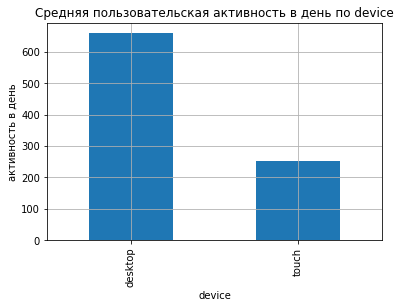

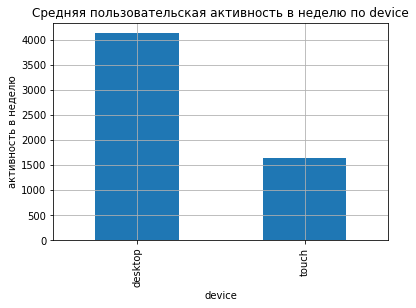

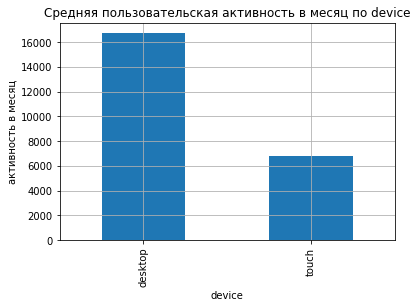

In [12]:
DAU_MAU_WAU (visit, 'start_session', 'uid','device')

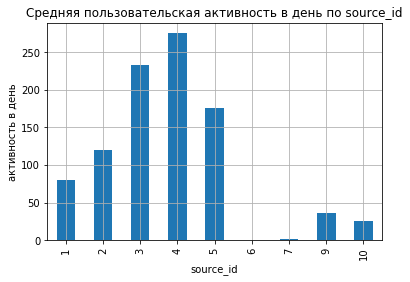

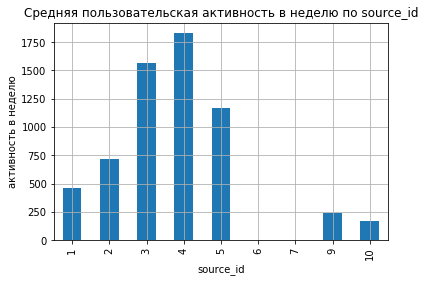

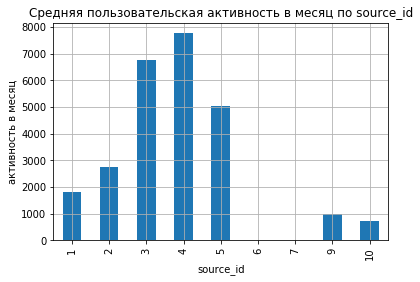

In [13]:
DAU_MAU_WAU (visit, 'start_session', 'uid','source_id')

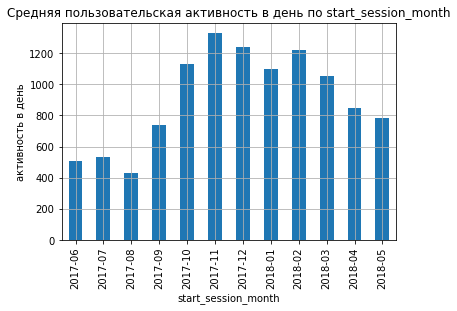

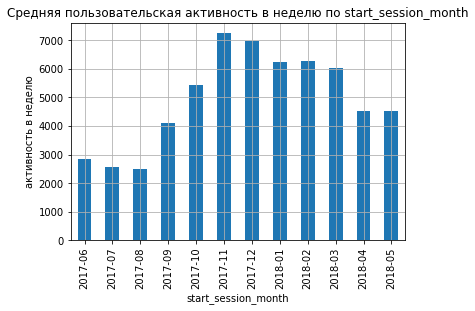

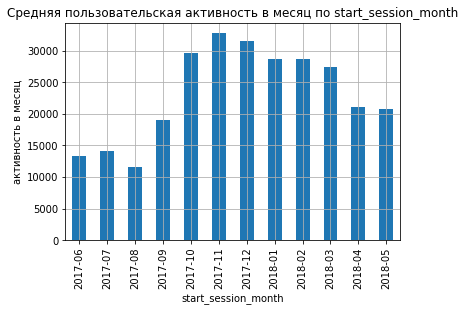

In [14]:
visit_tmp = visit.copy()
visit_tmp['start_session_month'] = visit_tmp['start_session_month'].dt.strftime('%Y-%m')
DAU_MAU_WAU (visit_tmp, 'start_session', 'uid','start_session_month')

#### Вывод

1) Активность пользователей ПК более чем в два раза выше, чем мобильных устройств. 

2) Рекламные источники 3,4,5 являются наиболее эффективными и привлекают больше всего пользователей для просмотра.

3) Рекламные источники 6,7 совершенно неэффективны, 9 и 10 также дают очень слабый результат

4) Наблюдается сезонная активность пользователей. Наиболее популярными являются месяцы с октября по март. Летом наблюдается значительный спад интереса к ресурсу.

* Выясним сколько сессий в день.

In [15]:
#функция подсчета среднего количества сессий в день
def Count_Session_Day(data,sign):
    count_sess = data.copy()
    count_sess['session_date'] = count_sess['start_session'].dt.date
    sessions_in_day = count_sess.groupby(['session_date',sign]).agg({'uid': ['count','nunique']})
    sessions_in_day.columns = ['n_sessions', 'n_users']
    sessions_in_day['sessions_count_in_day'] = sessions_in_day['n_sessions'] / sessions_in_day['n_users']
    #print('Среднее количество сессий в день : {:.2f}'.format(sessions_in_day['sessions_count_in_day'].mean()))
    mean_ses = sessions_in_day.groupby(sign)['sessions_count_in_day'].mean()
    Hist_Print(mean_ses,sign,'','Среднее количество сессий в день')
    #сделать ящик с усами
    return

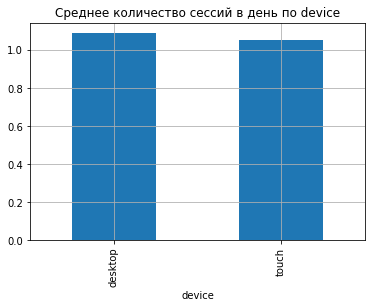

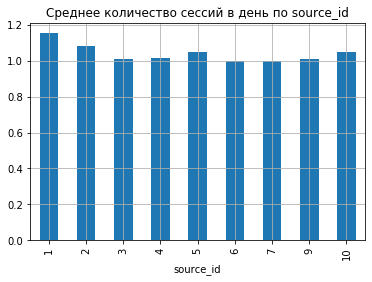

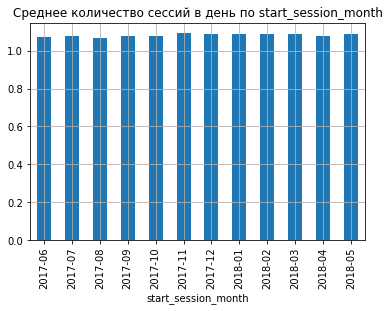

In [16]:
Count_Session_Day(visit,'device')
Count_Session_Day(visit,'source_id')
Count_Session_Day(visit_tmp,'start_session_month')

#### Вывод

Таким образом, в день один пользователь в среднем проводит в приложении 1 сессию практически независимо от устройства, источника рекламы и времени года. 

* Определим среднюю продолжительность сессии - ASL

In [17]:
#функция подсчета средней продолжительности сессии
def Duration_Session_Day(data,sign):
    duration_sess = data.copy()
    duration_sess['session_duration_sec'] = ((duration_sess['end_session'] - 
                                             duration_sess['start_session']).dt.seconds)
    mean__dur_ses = duration_sess.groupby(sign)['session_duration_sec'].mean()/60
    Hist_Print(mean__dur_ses,sign,'','Средняя продолжительность сессии пользователей (ASL) в мин.')
    return

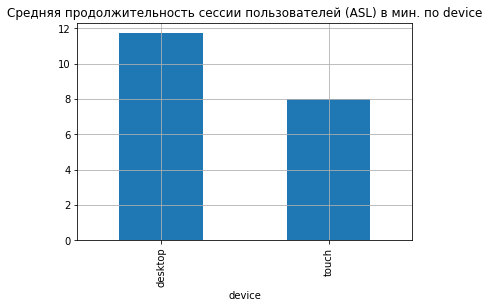

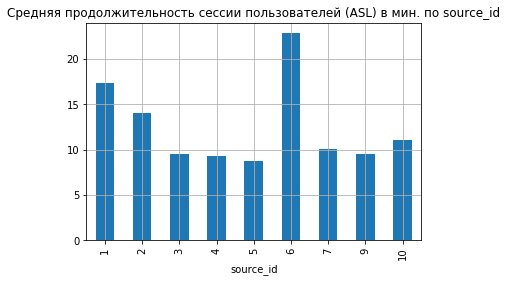

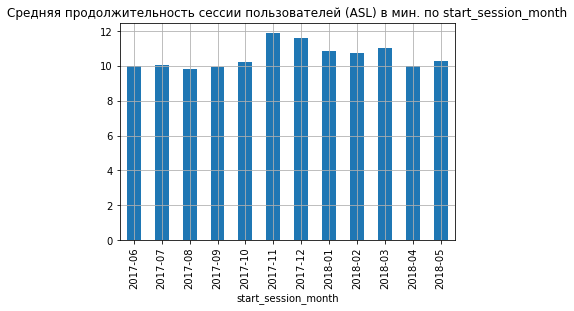

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64


In [18]:
Duration_Session_Day(visit,'device')
Duration_Session_Day(visit,'source_id')
Duration_Session_Day(visit_tmp,'start_session_month')
print(visit['source_id'].value_counts())

#### Вывод

1) Средняя продолжительность сессии пользователя зависит от используемого утсройства. Пользователи проводтят больше времени при использовании ПК - 12 минут, вместо 8 минут для мобильных устройств.

2) Средняя продолжительность сессии пользователя не зависит от времени года и колеблется около 10 минут.

3) Средняя продолжительность сессии пользователя немного зависит от источника рекламы. Это можно объяснить тем, что некоторые источники могут привлекать целевую аудиторию, которым действительно интересно воспользоваться ресурсом. Такими источниками являются 1 и 2. 

4) Может показаться, что рекламный источник 6 тоже достиг целевой аудитории, но этот выброс не является показательным, т.к. по этому источнику пришло всего 6 человек, что во вного раз меньше, чем для других источников.

In [19]:
#функция построения когорт по месецам
def Cohort_month (data,activity_date,id):
    coh_data = data.copy()
    act_month = activity_date + '_month'
    coh_data[act_month] = coh_data[activity_date].astype('datetime64[M]')
    
    #выделяем дату первой активности
    first_activity_date = coh_data.groupby(id)[activity_date].min().reset_index()
    first_activity_date.columns = [id,'first_activity_date']
    coh_data = pd.merge(coh_data,first_activity_date,on=id, how='left')
        
    #строим когорту с месячным периодом
    coh_data['first_activity_month'] = coh_data['first_activity_date'].astype('datetime64[M]')
       
    #найдём lifetime когорты
    coh_data['cohort_lifetime'] = (coh_data[act_month] - coh_data['first_activity_month'])/ np.timedelta64(1,'M')
    coh_data['cohort_lifetime'] = coh_data['cohort_lifetime'].round().astype('int') 
    
    #найдем размер когорты
    #cohort_size = coh_data.groupby(['first_activity_month']).agg({id:'nunique'}).reset_index()
    #cohort_size.columns =['first_activity_month','cohort_size']
    #coh_data = pd.merge(coh_data,cohort_size,on='first_activity_month', how='left')
        
    return coh_data

def Cohort_month_behav (data,activity_date,id,sign):
    coh_data = data.copy()
    act_month = activity_date + '_month'
    coh_data[act_month] = coh_data[activity_date].astype('datetime64[M]')
    
    #выделяем дату первой активности
    first_activity_date = coh_data.groupby([id,sign])[activity_date].min().reset_index()
    first_activity_date.columns = [id,sign,'first_activity_date']
    coh_data = pd.merge(coh_data,first_activity_date,on=[id,sign], how='left')
        
    #строим когорту с месячным периодом
    coh_data['first_activity_month'] = coh_data['first_activity_date'].astype('datetime64[M]')
       
    #найдём lifetime когорты
    coh_data['cohort_lifetime'] = (coh_data[act_month] - coh_data['first_activity_month'])/ np.timedelta64(1,'M')
    coh_data['cohort_lifetime'] = coh_data['cohort_lifetime'].round().astype('int') 
    
    return coh_data

#функция подсчета коэффициента удержания - Retention Rate
def Retention_Rate (data,id):
    #определим количество пользователей в когорте
    cohort_size = data.groupby(['first_activity_month']).agg({id:'nunique'}).reset_index()
    cohort_size.columns =['first_activity_month','cohort_size']
    #определим размер когорты в определенный месяц жизни
    cohort_lifetime_size = (data.groupby(['first_activity_month','cohort_lifetime']).agg({id:'nunique'})
                                                                                .reset_index())
    cohort_lifetime_size = cohort_lifetime_size.rename(columns={'uid':'cohort_lifetime_size'})
    cohort_lifetime_size = pd.merge(cohort_lifetime_size,cohort_size,on='first_activity_month', how='left')
    cohort_lifetime_size['ret_rate'] = (cohort_lifetime_size['cohort_lifetime_size']
                                               /cohort_lifetime_size['cohort_size'])
    cohort_lifetime_size['first_activity_month'] = (cohort_lifetime_size['first_activity_month']
                                                    .dt.strftime('%Y-%m'))
    retention_pivot = (cohort_lifetime_size
            .pivot_table(index='first_activity_month',columns='cohort_lifetime',values='ret_rate',aggfunc='sum'))
        
    return retention_pivot

#функция подсчета коэффициента удержания - Retention Rate
def Retention_Rate_behav (data,id,sign):
    #определим количество пользователей в когорте
    cohort_size = data.groupby(['first_activity_month', sign]).agg({id:'nunique'}).reset_index()
    cohort_size.columns =['first_activity_month',sign,'cohort_size']
    #определим размер когорты в определенный месяц жизни
    cohort_lifetime_size = (data.groupby(['first_activity_month',sign,'cohort_lifetime']).agg({id:'nunique'})
                                                                                        .reset_index())
    cohort_lifetime_size = cohort_lifetime_size.rename(columns={'uid':'cohort_lifetime_size'})
    cohort_lifetime_size = pd.merge(cohort_lifetime_size,cohort_size,on=['first_activity_month', sign], how='left')
    cohort_lifetime_size['ret_rate'] = (cohort_lifetime_size['cohort_lifetime_size']
                                               /cohort_lifetime_size['cohort_size'])
    
    retention_mean = cohort_lifetime_size.groupby([sign,'cohort_lifetime'])['ret_rate'].mean().reset_index()
    retention_pivot = (retention_mean
                           .pivot_table(index=sign,columns='cohort_lifetime',values='ret_rate',aggfunc='sum'))
        
    return retention_pivot

#функция построения тепловой карты
def Heat_Map(data_pivot,f,title):
    sns.set(style='white')
    plt.figure(figsize=(13, 6))
    plt.title(title)
    sns.heatmap(data_pivot, annot=True, fmt=f, linewidths=1, linecolor='gray')
    return


* Определим как часто люди возвращаются.

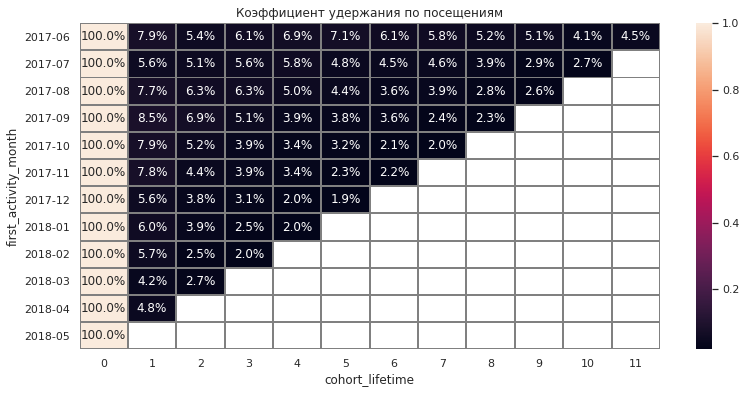

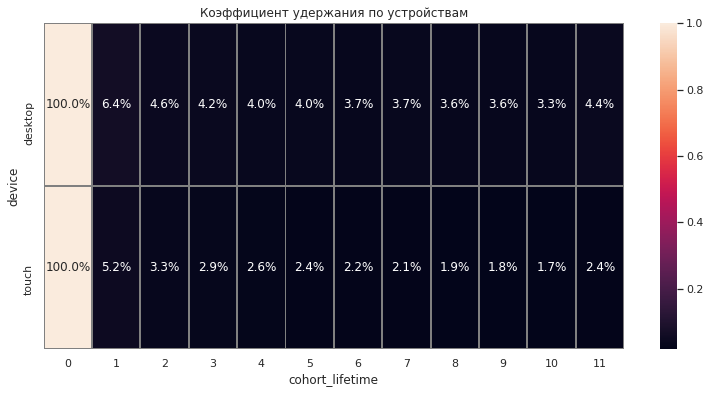

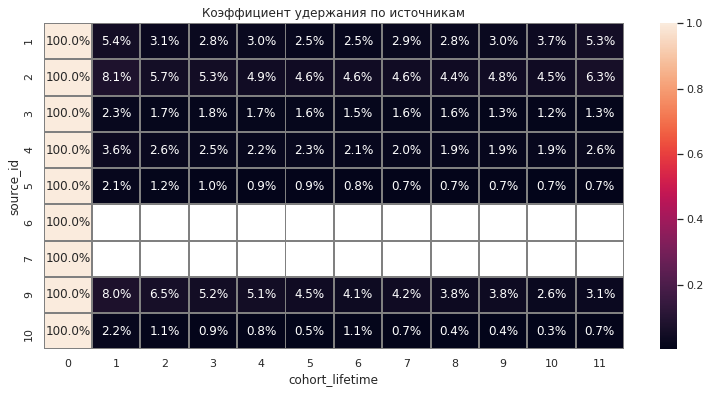

In [20]:
def Retention_Analitic (data,date_activity,id,title):
    cohort_data = Cohort_month (data,date_activity,id)
    Heat_Map(Retention_Rate(cohort_data, id),'.1%',title)
    return

def Retention_Analitic_behav (data,date_activity,id,sign,title):
    cohort_data = Cohort_month_behav (data,date_activity,id,sign)
    Heat_Map(Retention_Rate_behav(cohort_data, id, sign),'.1%',title)
    return

Retention_Analitic(visit,'start_session','uid','Коэффициент удержания по посещениям')
Retention_Analitic_behav(visit,'start_session','uid','device','Коэффициент удержания по устройствам')
Retention_Analitic_behav(visit,'start_session','uid','source_id','Коэффициент удержания по источникам')

#Retention_Analitic(visit,'start_session','uid','Коэффициент удержания по посещениям')
#Retention_Analitic(visit,'start_session','uid','Коэффициент удержания по посещениям')
#Retention_Analitic(visit,'start_session','uid','Коэффициент удержания по посещениям')

#### Вывод 

1) Коэффициент удержания по посещениям показывает импульсный характер покупок пользователей. Через месяц возвращаются менее 7,9% пользователей, далее намечается спад посещений. Это говорит о том, что основной контингент - разовые клиенты. 

2) В разрезе по устройствам захода видим, что с мобильных устройств интерес к сервису затухает значительно быстрее.  

### 2.2 Продажи

* Определим, когда люди начинают покупать

In [21]:
#строим профили пользователей
users = (visit.sort_values(by=['uid','start_session'])
               .groupby('uid').agg({'start_session': 'first','source_id':'first','device':'first'})
               .rename(columns={'start_session':'acquisition_session'}))
users['acquisition_date'] = users['acquisition_session'].astype('datetime64[D]')
users['acquisition_month'] = users['acquisition_session'].astype('datetime64[M]')
users = users.reset_index().set_index(['source_id','acquisition_date'])
users = (users
         .join(costs
               .rename(columns={'date_marceting_cost':'acquisition_date'})
               .set_index(['source_id','acquisition_date']), how='left')
        )
#display(costs)
#display(users)
#в cost 'acquisition_date' ?
#добавляем стоимость покупки каждому пользователю
user_cost = (users.groupby(['source_id','acquisition_date']).agg({'device':'count','costs':'max'})
                  .rename(columns={'device':'users'}))
user_cost['acquisition_cost'] = user_cost['costs']/user_cost['users']
#display(user_cost)
users = users.join(user_cost[['acquisition_cost']],how='left').reset_index()
users = (users.set_index('uid')[['acquisition_session','acquisition_date','acquisition_month',
                               'source_id','device','acquisition_cost']])
#display(users)
#определяем заплатил пользователь или нет
users = (users.join(orders.groupby('uid').agg({'data_time_transaction':'min'})
                         .rename(columns={'data_time_transaction':'first_buy_dt'}),how='left'))
users['first_buy_month'] = users['first_buy_dt'].astype('datetime64[M]')
users['payer'] = ~users['first_buy_dt'].isna()
display(users.head())

,acquisition_session,acquisition_date,acquisition_month,source_id,device,acquisition_cost,first_buy_dt,first_buy_month,payer
uid,,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-09-11 00:06:00,2017-09-01,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6,NaT,NaT,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-06-01 09:23:00,2017-06-01,True
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-06-01 16:47:00,2017-06-01,True
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6,NaT,NaT,False


In [22]:

first_activity_date = visit.groupby('uid')['start_session'].min().reset_index()
first_order_date = orders.groupby('uid')['data_time_transaction'].min().reset_index()
first_activity_date.columns = ['uid','first_user_date']
first_order_date.columns = ['uid','first_order_date']
orders = pd.merge(orders,first_activity_date,on='uid', how='left')
orders = pd.merge(orders,first_order_date,on='uid', how='left')

orders['for_order_period'] = (orders['first_order_date'] - orders['first_user_date'])/ np.timedelta64(1,'m')
orders['for_order_period'] = orders['for_order_period'].round().astype('int')
orders.head()


,data_time_transaction,revenue,uid,first_user_date,first_order_date,for_order_period
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,11
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,15
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,27


False    191647
True      36522
Name: payer, dtype: int64


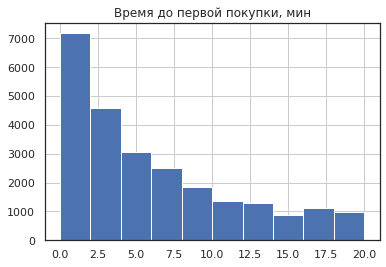

In [23]:
orders['for_order_period'].hist(range=(0,20))
plt.title('Время до первой покупки, мин')
orders['for_order_period'].describe()
print(users['payer'].value_counts())

#### Вывод

1) Как видим, большая часть покупателей делают приобретение через несколько минут после входа на сервис, что говорит о том, что они зашли на сайт целенаправленно.

2) Лишь 36 тыс. клиентов из 191 тыс. сделали хотя бы одно приобретение. Это менее 20%, остальные зашли только посмотреть. Эту информацию следует передать маркетологам.


* Сколько раз покупают за период


In [24]:
orders_count = orders.groupby('uid').agg({'revenue': 'count'}).reset_index()
orders_count.columns = ['uid','orders_count']
print('Средее количество заказов у каждого покупателя:')
print(orders_count['orders_count'].describe(percentiles=[0.1,0.2,0.5,0.8,0.9]).T)

Средее количество заказов у каждого покупателя:
count    36522.000000
mean         1.380373
std          3.454508
min          1.000000
10%          1.000000
20%          1.000000
50%          1.000000
80%          1.000000
90%          2.000000
max        239.000000
Name: orders_count, dtype: float64


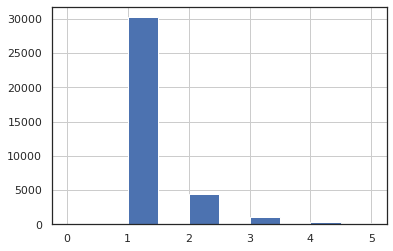

In [25]:
orders_count['orders_count'].hist(range=(0,5))
plt.show()

Более 80% пользователей делают покупки по одному разу, поэтому анализировать продажи в более детальном разрезе не считаю целесообразным.

* Определим какой средний чек

Заметим, что разбиение на когорты здесь не дает дополнительной информации, т.к. 80% покупок делается в первые 20 минут, и клиенты делают по одной покупке, значит в последующие недели и месяцы когорта не будет изменяться.

,order_month,revenue
0,2017-06,4.060106
1,2017-07,5.306589
2,2017-08,4.847139
3,2017-09,5.416448
4,2017-10,4.928280
5,2017-11,4.783518
6,2017-12,5.852139
7,2018-01,4.112927
8,2018-02,4.840095
9,2018-03,5.413930


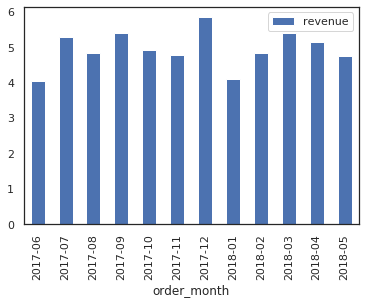

In [26]:
#найдем средний чек по месяцам
orders['order_month'] = orders['data_time_transaction'].astype('datetime64[M]')
mean_revenue = orders.groupby('order_month')['revenue'].mean().reset_index()
mean_revenue['order_month'] = mean_revenue['order_month'].dt.strftime('%Y-%m')
mean_revenue.plot.bar(x='order_month',y='revenue')
display(mean_revenue)


#### Вывод

Средий чек за месяц в целом держится на одном уровне.


#### Замечание

Была идея сопоставить покупки клиентов с их сессиями по времени - дата транзакции должна попадать в интервал между началом и концом сессии. Там сделать не получилось, т.к. для большого количества покупок дата транзакции не всегда попадает в вилку сессии. Пример - пользователь с uid=18346008462625591446. Таких транзакций около 30%, значит их игнорировать было бы неправильно. Поэтому отказываемся от идеи сопоставления покупок с сессиями.

In [27]:
#функция нахождения общего среднего чека по месяцам в разрезе задаваемого признака (устройство, источник)
def Mean_Revenue(data, sign):
    mean_revenue = data.groupby(['order_month',sign]).agg({'revenue':['sum','count']})
    mean_revenue.columns = ['rsum','rcount']
    mean_revenue = mean_revenue.reset_index()
    mean_revenue['order_month'] = mean_revenue['order_month'].dt.strftime('%Y-%m')
    mean_revenue['mean_revenue'] = mean_revenue['rsum'] / mean_revenue['rcount']
    return mean_revenue.pivot_table(index=sign,columns='order_month',values='mean_revenue',aggfunc='sum')


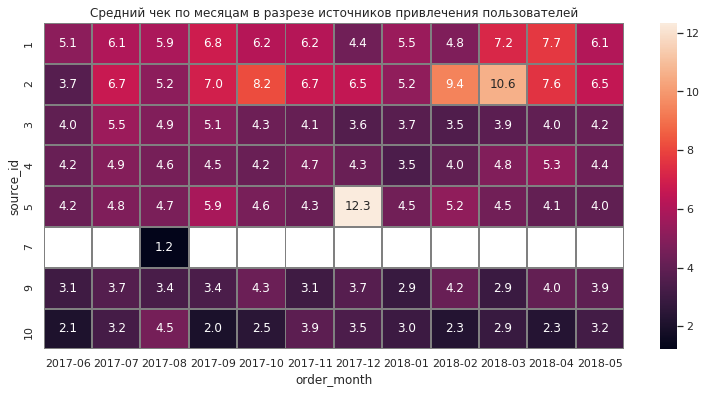

In [28]:
ord_with_users = orders.set_index('uid').join(users, how='left')
mr = Mean_Revenue(ord_with_users, 'source_id')
Heat_Map(mr,'.1f', 'Средний чек по месяцам в разрезе источников привлечения пользователей')

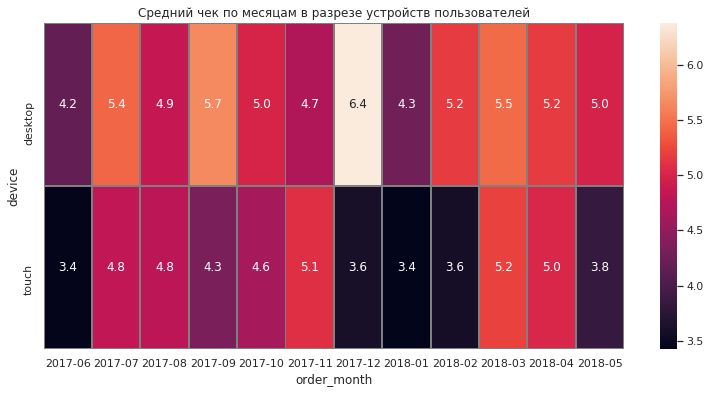

In [29]:
mdiv = Mean_Revenue(ord_with_users, 'device')
Heat_Map(mdiv,'.1f', 'Средний чек по месяцам в разрезе устройств пользователей')

#### Вывод

1) Средний чек несколько больше у клиентов, пришедших из рекламных источников 1 и 2.

2) Средний чек несколько больше у клиентов, пользующихся ПК, хотя эта разница незначительна.

* Сколько денег приносят? (LTV)

In [30]:
ltv = (orders.set_index('uid')
            .join(users, how='left')[['acquisition_month', 'source_id','device','first_buy_month','revenue']])
ltv['age_month'] = (((ltv['first_buy_month'] - ltv['acquisition_month']) / np.timedelta64(1,'M'))
                                                                             .round().astype('int'))

def BuildCacCohorts(signs):
    tmp = (users.groupby(signs)
           .agg({'payer':'sum', 'acquisition_cost':'sum'})
           .rename(columns = {'payer': 'cohort_size'})
          )
    
    tmp['cac'] = tmp['acquisition_cost'] / tmp['cohort_size']
    return tmp

def BuildLtv(data, signs):
    tmp = data.groupby(signs + ['age_month']).agg({'revenue':'sum'})
    tmp = pd.pivot_table(tmp, index = signs, columns = 'age_month', values = 'revenue', aggfunc = 'sum')
    tmp = tmp.cumsum(axis = 1)
    cac = BuildCacCohorts(signs)
    tmp = cac[['cohort_size']].join(tmp)
    tmp = tmp.div(tmp['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
    return tmp


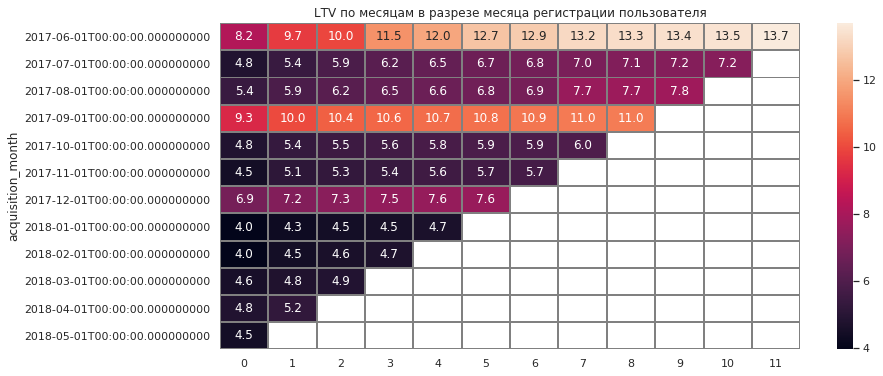

In [31]:
Heat_Map(BuildLtv(ltv, ['acquisition_month']),'.1f', 'LTV по месяцам в разрезе месяца регистрации пользователя')

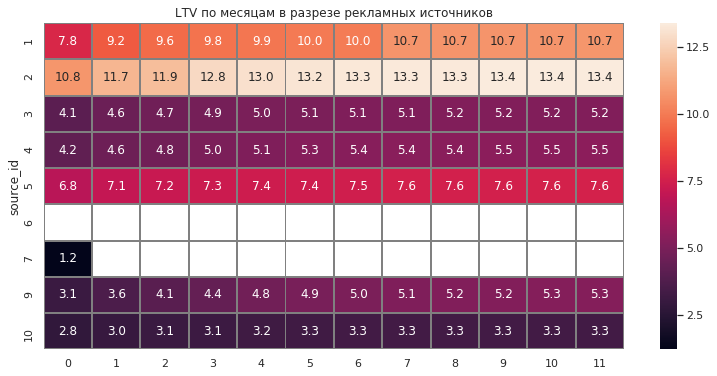

In [32]:
Heat_Map(BuildLtv(ltv, ['source_id']),'.1f', 'LTV по месяцам в разрезе рекламных источников')

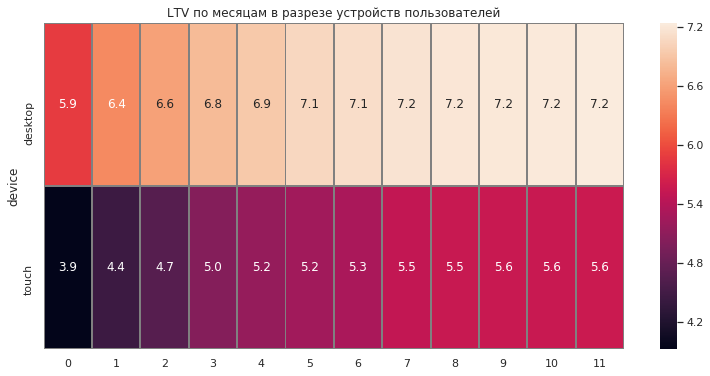

In [33]:
Heat_Map(BuildLtv(ltv, ['device']),'.1f', 'LTV по месяцам в разрезе устройств пользователей')

#### Вывод

1) По показателю LTV заметно лидируют рекламные источники 1 и 2. Источник 5 также заметно лучше других.

2) Пользователи ПК приносят сервису больше денег, чем мобильные клиенты.

### 2.3. Маркетинг

* Сколько денег потратили

Всего затрат: 329131.62
В среднем на одного пользователя: 9.011872843765401


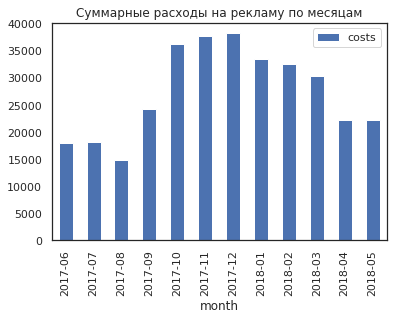

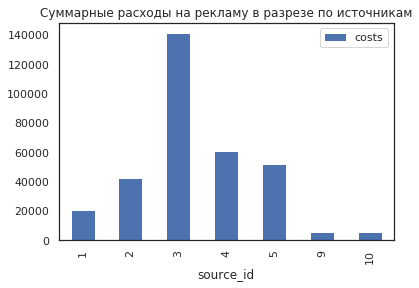

In [34]:
total_cac = costs['costs'].sum()
avg_per_client = costs['costs'].sum() / users['payer'].sum()
print('Всего затрат:', total_cac)
print('В среднем на одного пользователя:', avg_per_client)


costs['month'] = costs['date_marceting_cost'].astype('datetime64[M]').dt.strftime('%Y-%m')
total_per_month = costs.groupby(['month']).agg({'costs':'sum'})
total_per_month.plot.bar()
plt.title('Суммарные расходы на рекламу по месяцам')
plt.show()

total_per_source = costs.groupby(['source_id']).agg({'costs':'sum'})
total_per_source.plot.bar()
plt.title('Суммарные расходы на рекламу в разрезе по источникам')
plt.show()



#### Вывод

1) На рекламный источник 3 было потрачено значительно большее количество денег.

2) Заметно повышение затрат на рекламу в зимние месяцы.

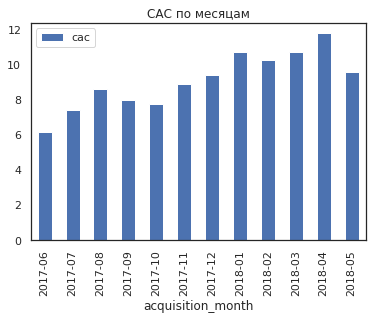

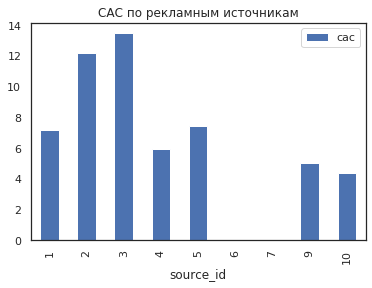

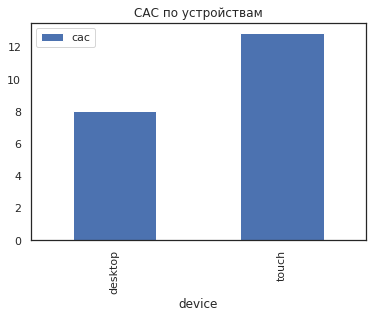

In [35]:
def CacPerSign(signs):
    return BuildCacCohorts(signs)[['cac']]

tmp = CacPerSign(['acquisition_month'])
tmp = tmp.reset_index()
tmp['acquisition_month'] = tmp['acquisition_month'].dt.strftime('%Y-%m')
tmp.set_index('acquisition_month').plot.bar()
plt.title('CAC по месяцам')
plt.show()

CacPerSign(['source_id']).plot.bar()
plt.title('CAC по рекламным источникам')
plt.show()

CacPerSign(['device']).plot.bar()
plt.title('CAC по устройствам')
plt.show()
    

#### Вывод

1) Наблюдается постепенное увеличение во времени затрат на рекламу для привлечения одного пользователя. Возможно, это связано с увеличением цен на рекламу, инфляцией и другими экономическими процессами.

2) Стоимость привлечения пользователей из рекламных источников 2 и 3 довольно высока

3) Стоимость привлечения пользователей мобильных приложений выше, чем для ПК

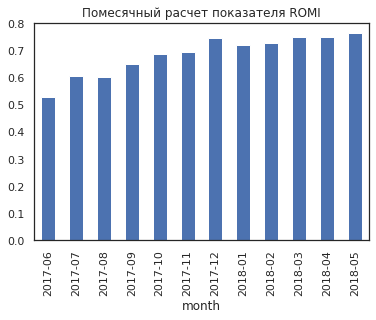

In [36]:
tmp_cac = costs.groupby('month').agg({'costs':'sum'})
tmp_rev = orders.groupby('order_month').agg({'revenue':'sum'}).reset_index()
tmp_rev['order_month'] = tmp_rev['order_month'].dt.strftime('%Y-%m')
tmp_rev = tmp_rev.rename(columns = {'order_month':'month'}).set_index(['month']).join(tmp_cac)
tmp_rev = tmp_rev.cumsum()
tmp_rev['romi'] = tmp_rev['revenue'] / tmp_rev['costs']
tmp_rev['romi'].plot.bar()
plt.title('Помесячный расчет показателя ROMI')
plt.show()


#### Вывод

Показатель пока не достиг отметки 1.0, что означает, что затраты на маркетинг пока не окупились.

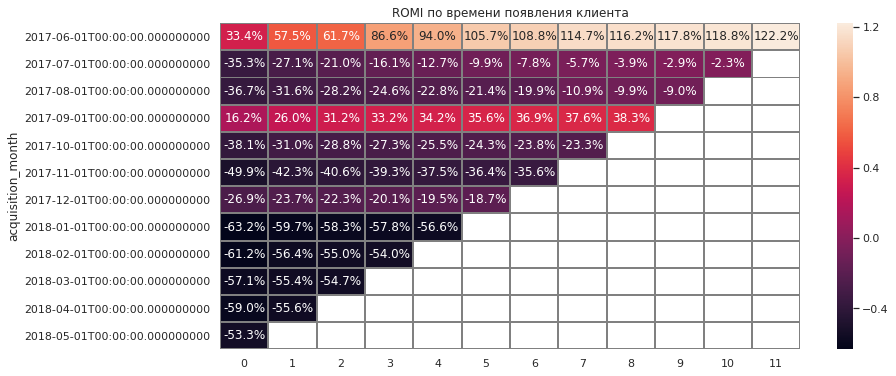

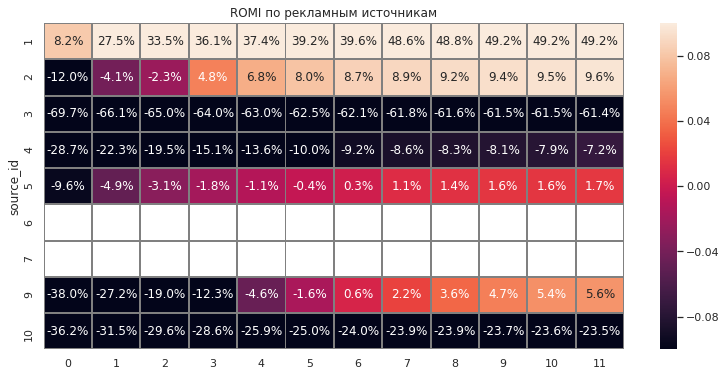

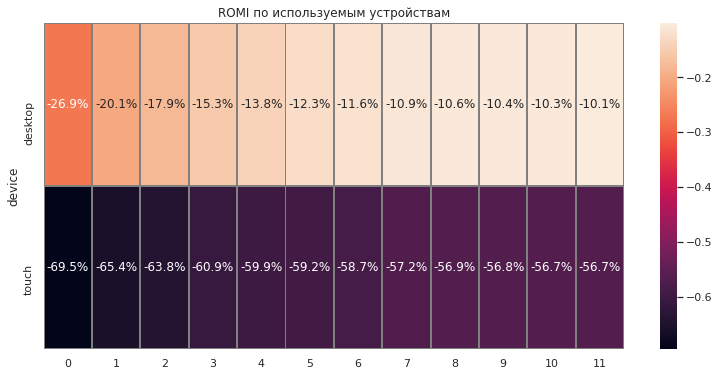

In [37]:
def RomiPerSign(signs):
    tmp_ltv = BuildLtv(ltv, signs)
    tmp_cac = BuildCacCohorts(signs)[['cac']]
    tmp = tmp_ltv.sub(tmp_cac['cac'], axis = 0).div(tmp_cac['cac'], axis = 0)
    return tmp

Heat_Map(RomiPerSign(['acquisition_month']),'.1%','ROMI по времени появления клиента')
Heat_Map(RomiPerSign(['source_id']),'.1%','ROMI по рекламным источникам')
Heat_Map(RomiPerSign(['device']),'.1%','ROMI по используемым устройствам')

#### Вывод 

1) Затраты на рекламу окупились только для источников 1,2,5 и 9. 

2) Реклама продукта для мобильных устройств крайне неэффективна и не окупается


### Рекомендации

1) Еще раз стоит отметить, что большинство покупателей сейчас - разовые клиенты. Основные усилия маркетологов следует направить на повторное привлечение пользователей в данный сервис.

2) Стоит пересмотреть работу с рекламными источниками. Так, например, источники 1,2,5 показали себя достаточно успешными. Вложения в них уже окупились, стоимость привлечения пользователей в них не так высока по сравнению с другими, а LTV напротив, довольно высок. Высокий LTV может свидетельствовать о том, что реклама попала в целевую аудиторию. 

3) У источников 1 и 2 средняя продолжительность сессии выше, что также может свидетельствовать о том, что реклама достигла целевой аудитории.

4) Рекламные источники 9 и 10 также дают очень слабый результат, но и затраты на них не велики. При этом источник 9 уже окупился, а 10 в небольшом минусе. Тенденция явно положительная, поэтому стоит попробовать вложить в них больше средств - вероятно, что это даст хорошие результаты.

5) Клиенты с мобильными устройствами не интересуются приложением, покупают меньше, их привлечение стоит дороже. Тем не менее, будущее за мобильными устройствами и сейчас они уже гораздо популярнее десктопов. Возможно, причина непопулярности сервиса на мобильных устройствах в том, что мобильное приложение не удобно. Стоит обратить на это внимание.

6) Лишь 19% всех пользователей сделали покупку в приложении. На этот факт стоит обратить внимание маркетологов.
